In [10]:
# GPT-4o
import numpy as np
import pandas as pd
import holidays
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from pandas.tseries.offsets import CustomBusinessDay
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import timedelta

# 예제 데이터프레임 생성
#df = pd.read_csv('timeseries_data.csv', parse_dates=['date'])
date_rng = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
df = pd.DataFrame(date_rng, columns=['date'])
df['target'] = np.random.randint(100, 1000, size=(len(date_rng)))
df.set_index('date', inplace=True)

# 시간 기반 피처 생성 (대한민국의 주말 및 공휴일 반영)
kr_holidays = holidays.KR()
kr_business_day = CustomBusinessDay(holidays=kr_holidays)

df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
#df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)  # 주말 여부
#df['is_holiday'] = df.index.isin(kr_holidays).astype(int)  # 공휴일 여부

# 시간 지연 피처 생성
df['lag_1'] = df['target'].shift(1)
df['lag_2'] = df['target'].shift(2)
df['lag_7'] = df['target'].shift(7)

# 이동 평균 피처 생성
df['rolling_mean_1'] = df['target'].rolling(window=1).mean()
df['rolling_mean_2'] = df['target'].rolling(window=2).mean()
df['rolling_mean_7'] = df['target'].rolling(window=7).mean()

# 변동률 피처 생성
df['rate_of_change'] = (df['target'] - df['target'].shift(1)) / df['target'].shift(1)

# 계절성 피처 생성
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

# 주기성 특성 (Cyclical Features)
df['sine_day'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['cosine_day'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

# 윈도우 통계 (Window Statistics)
df['target_max_7'] = df['target'].rolling(window=7).max()  # 7일간의 최대값
df['target_min_7'] = df['target'].rolling(window=7).min()  # 7일간의 최소값
df['target_std_7'] = df['target'].rolling(window=7).std()  # 7일간의 표준편차

# 연휴 전후 여부 특성 추가 (설날 및 추석 연휴 포함)
major_holidays = ['설날', '추석']
for date in df.index:
    if date in kr_holidays:
        holiday_name = kr_holidays[date]
        if holiday_name in major_holidays:
            df.loc[df.index == date - datetime.timedelta(days=1), 'is_holiday'] = 1
            df.loc[df.index == date + datetime.timedelta(days=1), 'is_holiday'] = 1

# kr_holidays를 datetime으로 변환
holiday_dates = pd.to_datetime(list(kr_holidays.keys()))
df['is_before_holiday'] = df.index.shift(-1, freq='D').isin(holiday_dates).astype(int)  # 연휴 전날 여부
df['is_after_holiday'] = df.index.shift(1, freq='D').isin(holiday_dates).astype(int)  # 연휴 다음 날 여부

# 특정 명절 및 중요 휴일 특성 추가
major_holidays.append('어린이날')
df['is_major_holiday'] = df.index.to_series().apply(lambda x: 1 if x in kr_holidays and kr_holidays[x] in major_holidays else 0)

# 대체공휴일 반영
replacement_holidays = []
for date in kr_holidays:
    if date.weekday() in [5, 6]:  # 토요일(5)이나 일요일(6)에 해당하는 공휴일일 경우
        replacement_date = date + datetime.timedelta(days=1)
        while replacement_date.weekday() in [5, 6] or replacement_date in kr_holidays:
            replacement_date += datetime.timedelta(days=1)
        replacement_holidays.append(replacement_date)
df['is_replacement_holiday'] = df.index.isin(pd.to_datetime(replacement_holidays)).astype(int)

# 공휴일 전후 주중/주말 여부 추가
#df['is_holiday_weekend'] = ((df['is_holiday'] == 1) & df['is_weekend'] == 1).astype(int)  # 공휴일이 주말인 경우
#df['is_holiday_weekday'] = ((df['is_holiday'] == 1) & df['is_weekend'] == 0).astype(int)  # 공휴일이 주중인 경우
#df['is_month_end'] = df.index.is_month_end.astype(int)  # 월별 마지막 날 여부
#df['is_month_start'] = df.index.is_month_start.astype(int)  # 월초 여부

# 외부 변수 추가 (예: 기온 데이터)
#external_data = pd.read_csv('external_data.csv')
#df = df.merge(external_data, on='date', how='left')
#df['temperature'] = df['temperature']

# 결측값 처리 (특징 벡터 생성 후 생길 수 있는 NaN 처리)
#df.fillna(method='bfill', inplace=True)
#df.fillna(method='ffill', inplace=True)
df.bfill(inplace=True)
df.ffill(inplace=True)

# 특성과 타겟 분리
X = df.drop('target', axis=1)
y = df['target']

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 학습
model = LGBMRegressor()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2835
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 20
[LightGBM] [Info] Start training from score 559.834475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


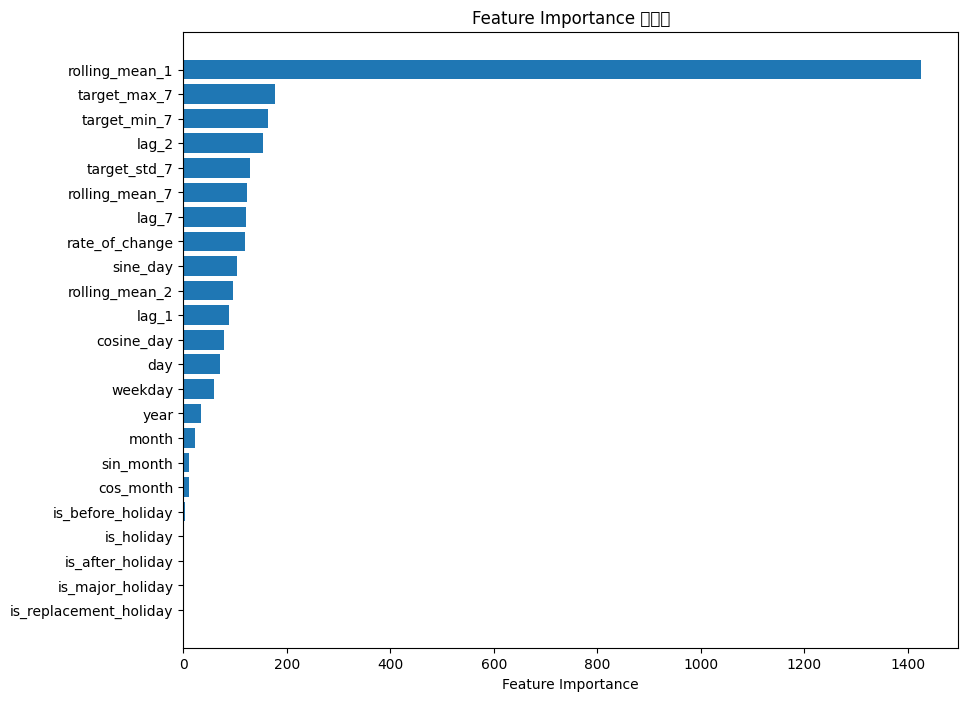

In [11]:
# 특성 중요도 계산 및 시각화 추가
import matplotlib.pyplot as plt  # 시각화를 위한 matplotlib 임포트

# 모델의 특성 중요도 추출
feature_importances = model.feature_importances_
feature_names = X.columns

# 특성 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 8))  # 그래프 크기 설정
plt.barh(importance_df['feature'], importance_df['importance'])  # 수평 막대그래프 생성
plt.xlabel('Feature Importance')  # x축 레이블 설정
plt.title('Feature Importance 시각화')  # 그래프 제목 설정
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 표시
plt.show()  # 그래프 출력

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


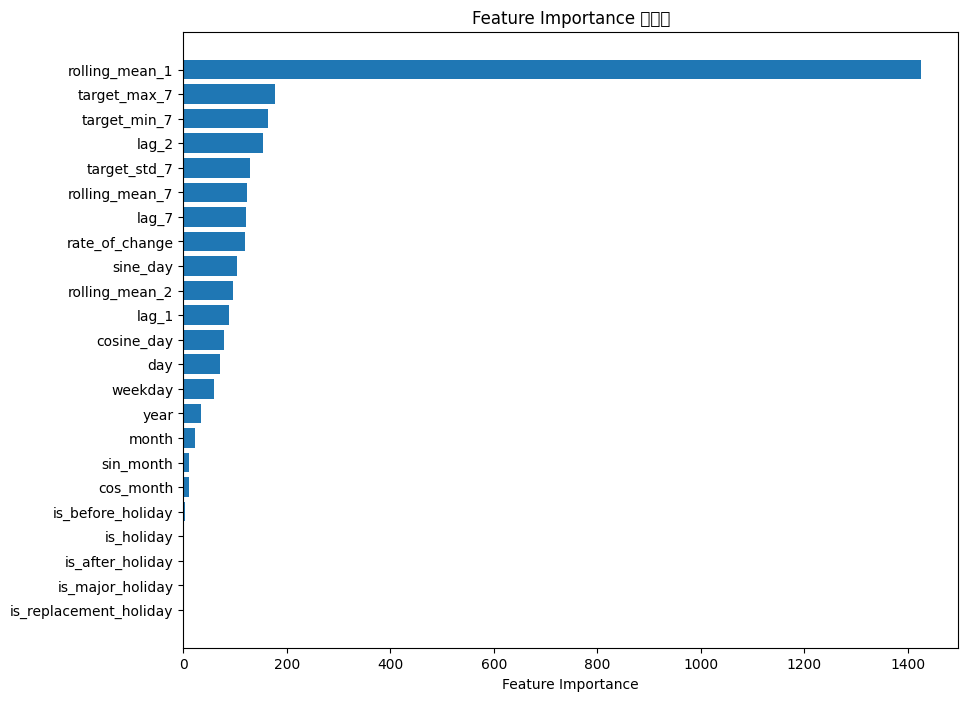

In [ ]:
# 특성 중요도 계산 및 시각화 추가
import matplotlib.pyplot as plt  # 시각화를 위한 matplotlib 임포트

# 모델의 특성 중요도 추출
feature_importances = model.feature_importances_
feature_names = X.columns

# 특성 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 8))  # 그래프 크기 설정
plt.barh(importance_df['feature'], importance_df['importance'])  # 수평 막대그래프 생성
plt.xlabel('Feature Importance')  # x축 레이블 설정
plt.title('Feature Importance 시각화')  # 그래프 제목 설정
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 표시
plt.show()  # 그래프 출력

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3636
[LightGBM] [Info] Number of data points in the train set: 852, number of used features: 25
[LightGBM] [Info] Start training from score 574.684272


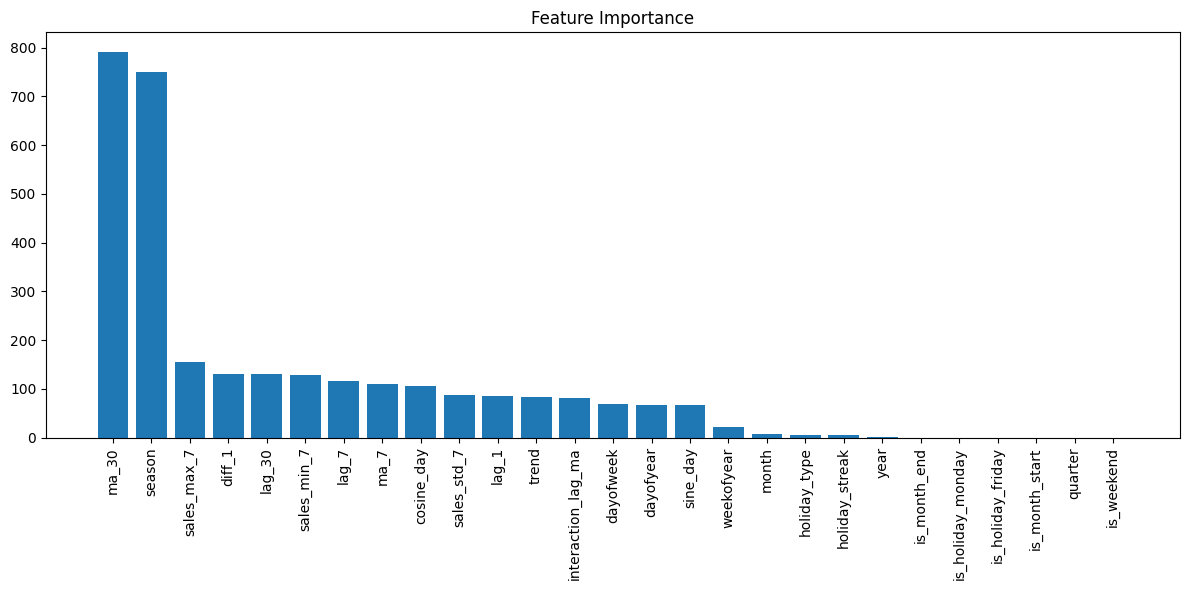

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3636
[LightGBM] [Info] Number of data points in the train set: 852, number of used features: 25
[LightGBM] [Info] Start training from score 574.684272
MSE for Original Feature Set: 128.30521888571323
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 852, number of used features: 10
[LightGBM] [Info] Start training from score 574.684272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
MSE for Top 10 Features: 126.37022069544606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of

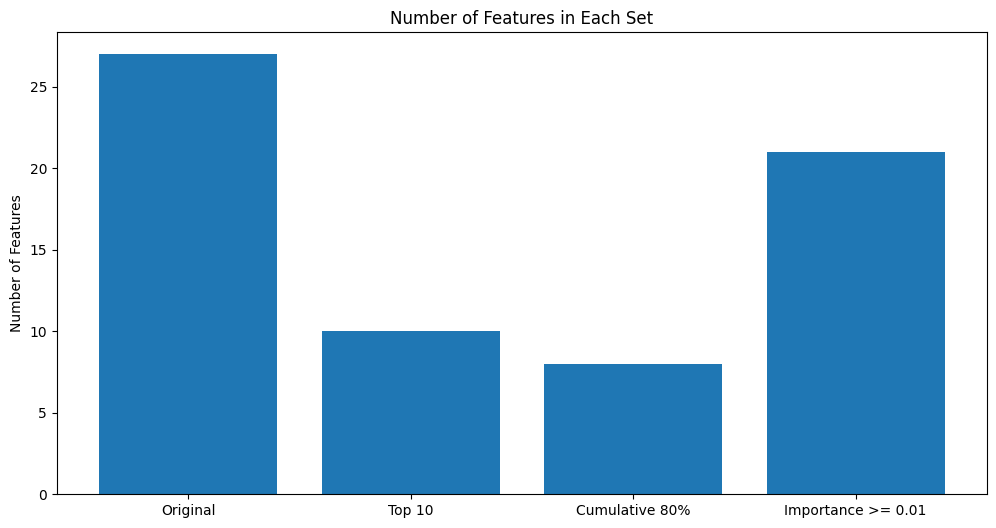

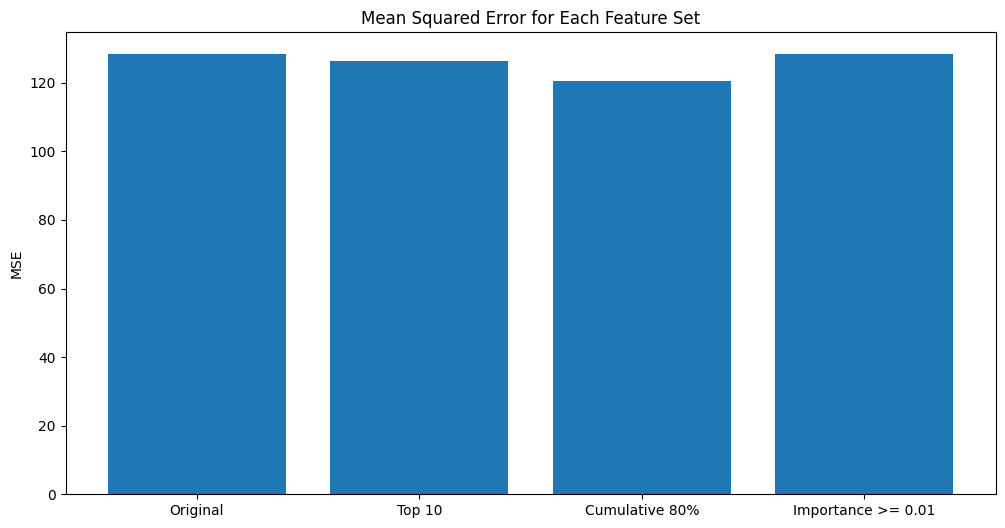


Top 10 Features:
['ma_30', 'season', 'sales_max_7', 'diff_1', 'lag_30', 'sales_min_7', 'lag_7', 'ma_7', 'cosine_day', 'sales_std_7']

Features in Cumulative 80% Importance:
['ma_30', 'season', 'sales_max_7', 'diff_1', 'lag_30', 'sales_min_7', 'lag_7', 'ma_7']

Features with Importance >= 0.01:
['ma_30', 'season', 'sales_max_7', 'diff_1', 'lag_30', 'sales_min_7', 'lag_7', 'ma_7', 'cosine_day', 'sales_std_7', 'lag_1', 'trend', 'interaction_lag_ma', 'dayofweek', 'dayofyear', 'sine_day', 'weekofyear', 'month', 'holiday_type', 'holiday_streak', 'year']


In [2]:
# claude3.5를 활용한 시계열예측 설계
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import holidays
import matplotlib.pyplot as plt
from datetime import timedelta

# 예시 데이터 생성
date_rng = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
df = pd.DataFrame(date_rng, columns=['date'])
df['sales'] = np.random.randint(100, 1000, size=(len(date_rng)))
df.set_index('date', inplace=True)

# 한국 공휴일 정보 가져오기
kr_holidays = holidays.KR()

def is_korean_holiday(date):
    holiday_name = kr_holidays.get(date)
    
    if holiday_name:
        # 설날과 추석 처리
        if "설날" in holiday_name or "추석" in holiday_name:
            # 해당 날짜와 전후 1일을 명절 연휴로 처리
            return 2
        # 대체 공휴일 처리
        elif "대체공휴일" in holiday_name:
            return 3
        # 기타 공휴일
        else:
            return 1
    
    # 명절 연휴 추가 처리 (설날과 추석 전후 3일)
    for i in range(-1, 2):  # -1, 0, 1
        adjacent_date = date + timedelta(days=i)
        adjacent_holiday = kr_holidays.get(adjacent_date)
        if adjacent_holiday and ("설날" in adjacent_holiday or "추석" in adjacent_holiday):
            return 2

    # 평일
    return 0

# Feature Engineering

# 1. 시차 변수 (Lag Features)
df['lag_1'] = df['sales'].shift(1)
df['lag_7'] = df['sales'].shift(7)
df['lag_30'] = df['sales'].shift(30)

# 2. 이동 평균 (Moving Averages)
df['ma_7'] = df['sales'].rolling(window=7).mean()
df['ma_30'] = df['sales'].rolling(window=30).mean()

# 3. 시간 관련 특성 (Time-based Features)
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['weekofyear'] = df.index.isocalendar().week
df['is_month_start'] = df.index.is_month_start.astype(int)
df['is_month_end'] = df.index.is_month_end.astype(int)
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# 공휴일 정보 추가
df['holiday_type'] = df.index.map(is_korean_holiday)

# 요일별 공휴일 여부
df['is_holiday_monday'] = ((df['dayofweek'] == 0) & (df['holiday_type'] > 0)).astype(int)
df['is_holiday_friday'] = ((df['dayofweek'] == 4) & (df['holiday_type'] > 0)).astype(int)

# 연휴 기간 계산
df['holiday_streak'] = df['holiday_type'].rolling(window=3, center=True).sum()

# 4. 추세 및 계절성 분해 (간단한 방법)
df['trend'] = np.arange(len(df))
df['season'] = df['sales'] - df['ma_30']

# 5. 주기성 특성 (Cyclical Features)
df['sine_day'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['cosine_day'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

# 6. 윈도우 통계 (Window Statistics)
df['sales_max_7'] = df['sales'].rolling(window=7).max()
df['sales_min_7'] = df['sales'].rolling(window=7).min()
df['sales_std_7'] = df['sales'].rolling(window=7).std()

# 7. 차분 (Differencing)
df['diff_1'] = df['sales'].diff()

# 8. 교차 변수 (Interaction Features)
df['interaction_lag_ma'] = df['lag_1'] * df['ma_7']

# NaN 값 제거
df.dropna(inplace=True)

# 특성과 타겟 분리
X = df.drop('sales', axis=1)
y = df['sales']

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LightGBM 모델 학습
model = LGBMRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 특성 중요도 계산
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Feature Reduction 방법

def select_top_n_features(feature_importance, n):
    return feature_importance.head(n)['feature'].tolist()

def select_cumulative_importance(feature_importance, threshold):
    total_importance = feature_importance['importance'].sum()
    feature_importance = feature_importance.copy()
    feature_importance['normalized_importance'] = feature_importance['importance'] / total_importance
    feature_importance['cumulative_importance'] = feature_importance['normalized_importance'].cumsum()
    return feature_importance[feature_importance['cumulative_importance'] <= threshold]['feature'].tolist()

def select_importance_threshold(feature_importance, threshold):
    return feature_importance[feature_importance['importance'] >= threshold]['feature'].tolist()

# 각 방법 적용
top_10_features = select_top_n_features(feature_importance, 10)
cumulative_80_features = select_cumulative_importance(feature_importance, 0.8)
importance_threshold_features = select_importance_threshold(feature_importance, 0.01)

# 선택된 특성들을 사용하여 새로운 데이터셋 생성
X_top_10 = X[top_10_features]
X_cumulative_80 = X[cumulative_80_features]
X_importance_threshold = X[importance_threshold_features]

# 각 reduced feature set으로 모델 학습 및 평가
def train_and_evaluate(X, y, feature_set_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = LGBMRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE for {feature_set_name}: {mse}")
    return model, mse

original_model, original_mse = train_and_evaluate(X, y, "Original Feature Set")
top_10_model, top_10_mse = train_and_evaluate(X_top_10, y, "Top 10 Features")
cumulative_80_model, cumulative_80_mse = train_and_evaluate(X_cumulative_80, y, "Cumulative 80% Importance Features")
importance_threshold_model, importance_threshold_mse = train_and_evaluate(X_importance_threshold, y, "Features with Importance >= 0.01")

# 결과 비교
results = pd.DataFrame({
    'Feature Set': ['Original', 'Top 10', 'Cumulative 80%', 'Importance >= 0.01'],
    'Number of Features': [X.shape[1], len(top_10_features), len(cumulative_80_features), len(importance_threshold_features)],
    'MSE': [original_mse, top_10_mse, cumulative_80_mse, importance_threshold_mse]
})

print(results)

# 선택된 특성 세트의 분포 시각화
plt.figure(figsize=(12, 6))
plt.bar(results['Feature Set'], results['Number of Features'])
plt.title('Number of Features in Each Set')
plt.ylabel('Number of Features')
plt.show()

# MSE 비교 시각화
plt.figure(figsize=(12, 6))
plt.bar(results['Feature Set'], results['MSE'])
plt.title('Mean Squared Error for Each Feature Set')
plt.ylabel('MSE')
plt.show()

# 최종 선택된 특성 세트 출력
print("\nTop 10 Features:")
print(top_10_features)
print("\nFeatures in Cumulative 80% Importance:")
print(cumulative_80_features)
print("\nFeatures with Importance >= 0.01:")
print(importance_threshold_features)